Loaded X_processed shape: (303, 20)
Loaded y_processed shape: (303,)

First 5 rows of loaded X_processed:
        age  trestbps      chol   thalach   oldpeak  sex_1  cp_2  cp_3  cp_4  \
0  0.948726  0.757525 -0.264900  0.017197  1.087338      1     0     0     0   
1  1.392002  1.611220  0.760415 -1.821905  0.397182      1     0     0     1   
2  1.392002 -0.665300 -0.342283 -0.902354  1.346147      1     0     0     1   
3 -1.932564 -0.096170  0.063974  1.637359  2.122573      1     0     1     0   
4 -1.489288 -0.096170 -0.825922  0.980537  0.310912      0     1     0     0   

   fbs_1  restecg_1  restecg_2  exang_1  slope_2  slope_3  ca_1.0  ca_2.0  \
0      1          0          1        0        0        1       0       0   
1      0          0          1        1        1        0       0       0   
2      0          0          1        1        1        0       0       1   
3      0          0          0        0        0        1       0       0   
4      0          0         

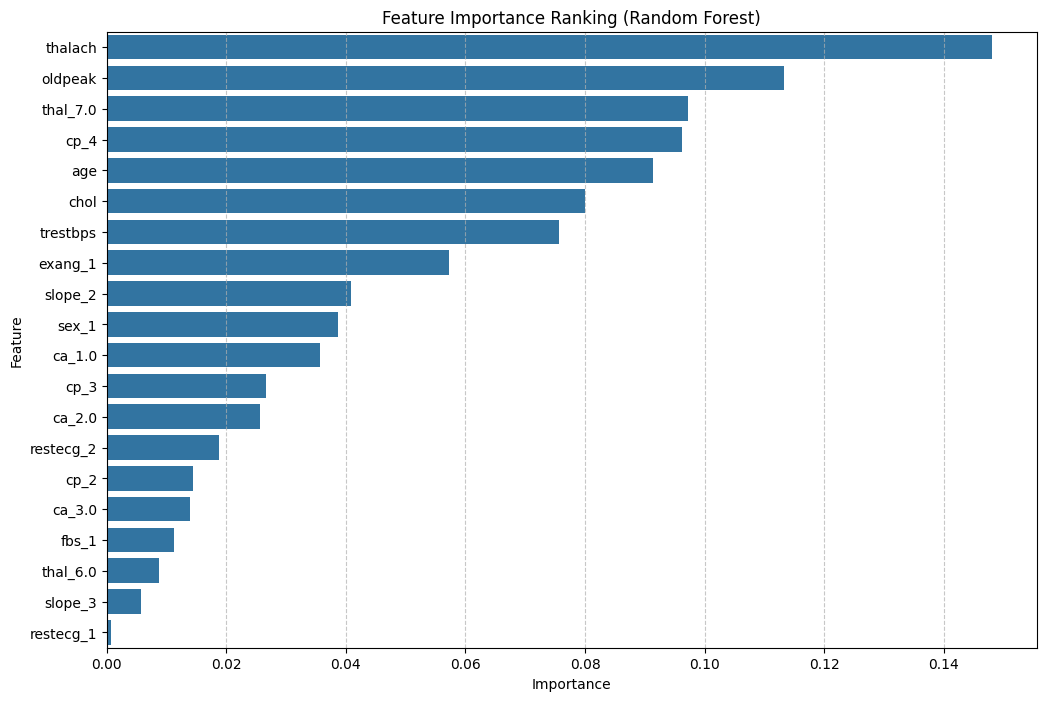

In [1]:
# 03_feature_selection.ipynb

# 1. Use Feature Importance (Random Forest / XGBoost feature importance scores) to rank variables.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier # For Feature Importance
# from xgboost import XGBClassifier # You can use XGBoost as well if installed and preferred
from sklearn.feature_selection import RFE # For Recursive Feature Elimination
from sklearn.feature_selection import SelectKBest, chi2 # For Chi-Square Test

# Load the preprocessed data (X_final from 01_data_preprocessing.ipynb)
input_data_path = '../data/' # Relative path to data folder from notebooks folder
X_processed = pd.read_csv(os.path.join(input_data_path, 'X_processed.csv'))
y_processed = pd.read_csv(os.path.join(input_data_path, 'y_processed.csv'))

# Make sure y_processed is a 1D array/Series for scikit-learn models
y_processed = y_processed.iloc[:, 0] # Converts DataFrame to Series if it's a single column DataFrame

print("Loaded X_processed shape:", X_processed.shape)
print("Loaded y_processed shape:", y_processed.shape)
print("\nFirst 5 rows of loaded X_processed:")
print(X_processed.head())

# --- Feature Importance using Random Forest Classifier ---
# Initialize a Random Forest Classifier
# Use a random_state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the preprocessed data
rf_model.fit(X_processed, y_processed)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': importances
})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances_df)

# Visualize feature importances 
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importance Ranking (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Store the sorted feature names for later use
ranked_features_rf = feature_importances_df['Feature'].tolist()

## 2. Apply Recursive Feature Elimination (RFE) to select the best predictors.

In [2]:
# Initialize a base estimator (e.g., Logistic Regression or Random Forest)
# We'll use RandomForestClassifier as it worked well for feature importance.
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the estimator and the number of features to select
# A common practice is to start with a number of features slightly less than total
# or iterate to find optimal. For now, let's target selecting, for example, 10 features.
# You can adjust n_features_to_select based on your analysis or a target number.
# Let's start with a reasonable number, for instance, 10 features.
n_features_to_select_rfe = 10 # This number can be adjusted later if needed

rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select_rfe, step=1)

# Fit RFE on the processed data
rfe_selector.fit(X_processed, y_processed)

# Get the selected features and their ranking
selected_features_rfe_mask = rfe_selector.support_
selected_features_rfe = X_processed.columns[selected_features_rfe_mask].tolist()
feature_ranking_rfe = rfe_selector.ranking_

# Create a DataFrame for RFE ranking
rfe_ranking_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Ranking': feature_ranking_rfe,
    'Selected_by_RFE': selected_features_rfe_mask
})

# Sort by ranking (1 means selected, higher numbers mean less important)
rfe_ranking_df = rfe_ranking_df.sort_values(by='Ranking', ascending=True)

print(f"\nFeatures Selected by RFE (Top {n_features_to_select_rfe}):")
print(rfe_ranking_df[rfe_ranking_df['Selected_by_RFE']])

print("\nFull RFE Ranking:")
print(rfe_ranking_df)

# Store the selected features by RFE
selected_features_rfe_list = selected_features_rfe


Features Selected by RFE (Top 10):
     Feature  Ranking  Selected_by_RFE
0        age        1             True
1   trestbps        1             True
2       chol        1             True
3    thalach        1             True
4    oldpeak        1             True
5      sex_1        1             True
12   exang_1        1             True
8       cp_4        1             True
13   slope_2        1             True
19  thal_7.0        1             True

Full RFE Ranking:
      Feature  Ranking  Selected_by_RFE
0         age        1             True
1    trestbps        1             True
2        chol        1             True
3     thalach        1             True
4     oldpeak        1             True
5       sex_1        1             True
12    exang_1        1             True
8        cp_4        1             True
13    slope_2        1             True
19   thal_7.0        1             True
15     ca_1.0        2            False
7        cp_3        3            Fa

## 3. Use Chi-Square Test to check feature significance.


In [3]:

# Identify categorical columns that resulted from one-hot encoding
# These are the columns that have '_X.X' or similar suffixes, or are known to be binary flags.
# We'll use the list of original categorical_cols and check their encoded forms.
# From previous steps, we know the encoded columns are for:
# 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'

# Let's get the list of original categorical columns that were encoded
original_categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Filter X_processed to get only the columns that are results of one-hot encoding
# We need to explicitly find these columns in X_processed
chi_square_features = []
for col in X_processed.columns:
    # Check if the column name contains part of the original categorical names + '_'
    # This is a heuristic, better would be to store encoded column names from step 3 in preprocessing
    # For now, let's select based on our knowledge of the encoded columns structure
    if any(orig_col in col for orig_col in original_categorical_cols) or col in original_categorical_cols:
        # Exclude original numerical columns that might contain categorical names
        # Make sure they are binary/categorical, not continuous numerical.
        # After one-hot encoding, these columns should be binary (0 or 1)
        if X_processed[col].nunique() <= X_processed.shape[0] * 0.1: # Heuristic for potentially categorical if many unique vals
             # Better check if the column name implies it's an encoded feature
            if '_' in col and col.split('_')[0] in original_categorical_cols:
                chi_square_features.append(col)
            elif col in ['sex_1', 'fbs_1', 'exang_1']: # Specific binary encoded original features
                chi_square_features.append(col)

# Let's manually define the actual encoded categorical columns based on previous output
# These are columns that were *created* by one-hot encoding.
# We need to ensure we don't include original numerical columns.
# A more robust way would be to get them from X_encoded.columns minus true_numerical_cols
encoded_categorical_cols_for_chi2 = [
    'sex_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_1', 'restecg_1', 'restecg_2',
    'exang_1', 'slope_2', 'slope_3', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_6.0', 'thal_7.0'
]

# Ensure these columns actually exist in X_processed
encoded_categorical_cols_for_chi2 = [col for col in encoded_categorical_cols_for_chi2 if col in X_processed.columns]

print(f"\nCategorical columns for Chi-Square Test: {encoded_categorical_cols_for_chi2}")

# Apply Chi-Square Test
# SelectKBest selects features based on the k highest scores.
# chi2 is the scoring function for categorical features.
# We will get scores for all identified categorical features.
chi2_selector = SelectKBest(chi2, k='all') # k='all' to get scores for all features

# Fit the selector
chi2_selector.fit(X_processed[encoded_categorical_cols_for_chi2], y_processed)

# Get scores and p-values
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_

# Create a DataFrame for Chi-Square results
chi2_results_df = pd.DataFrame({
    'Feature': encoded_categorical_cols_for_chi2,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_pvalues
})

# Sort by Chi2_Score in descending order (higher score means stronger relationship)
chi2_results_df = chi2_results_df.sort_values(by='Chi2_Score', ascending=False)

print("\nChi-Square Test Results:")
print(chi2_results_df)

# Interpret p-values: A low p-value (e.g., < 0.05) indicates a significant relationship.
print("\nFeatures with P-Value < 0.05 (Statistically Significant):")
print(chi2_results_df[chi2_results_df['P_Value'] < 0.05])

# Store significant features for later use
significant_chi2_features = chi2_results_df[chi2_results_df['P_Value'] < 0.05]['Feature'].tolist()


Categorical columns for Chi-Square Test: ['sex_1', 'cp_2', 'cp_3', 'cp_4', 'fbs_1', 'restecg_1', 'restecg_2', 'exang_1', 'slope_2', 'slope_3', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_6.0', 'thal_7.0']

Chi-Square Test Results:
      Feature  Chi2_Score       P_Value
14   thal_7.0   42.958360  5.591745e-11
3        cp_4   42.410097  7.400700e-11
7     exang_1   38.052613  6.886243e-10
2        cp_3   21.551109  3.445235e-06
8     slope_2   20.624160  5.588639e-06
11     ca_2.0   19.509795  1.000851e-05
1        cp_2   15.646367  7.635913e-05
10     ca_1.0   12.461167  4.155004e-04
12     ca_3.0   12.330323  4.456592e-04
0       sex_1    7.432845  6.404399e-03
6   restecg_2    3.987845  4.582964e-02
13   thal_6.0    3.133971  7.667677e-02
5   restecg_1    1.366567  2.424027e-01
9     slope_3    1.073891  3.000681e-01
4       fbs_1    0.164669  6.848935e-01

Features with P-Value < 0.05 (Statistically Significant):
      Feature  Chi2_Score       P_Value
14   thal_7.0   42.958360  5.591745e-

## 4. Select only the most relevant features for modeling.

In [4]:

# Combine results from all three methods to make a final selection.
# We'll prioritize features that appear in multiple selection methods,
# or are consistently ranked high.

# Option 1: Based on top N features from Random Forest importance
# Let's decide on a threshold or a number of top features.
# From the RF importance, we saw that many features have very low importance.
# Let's pick, for example, the top 12 features from Random Forest importance.
# You can adjust this number based on your judgment of the plot.
top_n_rf_features = 12
selected_features_final_rf_subset = feature_importances_df['Feature'].head(top_n_rf_features).tolist()
print(f"\nTop {top_n_rf_features} features from Random Forest Importance:")
print(selected_features_final_rf_subset)

# Option 2: Combine RFE selected features and significant Chi-Square features
# This approach ensures we capture features that are important by different criteria.
combined_selected_features = list(set(selected_features_rfe_list + significant_chi2_features))
print("\nFeatures selected by RFE OR significant by Chi-Square:")
print(combined_selected_features)

# For simplicity and robustness, let's go with the top features from Random Forest
# as it considers interaction and importance across all feature types.
# You could also take the intersection or union of the lists, depending on strategy.
# Let's use the top N features identified by Random Forest as our primary selection.
final_selected_features = selected_features_final_rf_subset

print(f"\nFinal set of selected features for modeling (using top {top_n_rf_features} from Random Forest):")
print(final_selected_features)
print(f"Total selected features: {len(final_selected_features)}")

# Create the final dataset with only the selected features
X_selected = X_processed[final_selected_features]

print("\nFirst 5 rows of X after Feature Selection:")
print(X_selected.head())
print(f"Shape of X after Feature Selection: {X_selected.shape}")

# Save the selected features for the next steps (Supervised Learning)
selected_features_path = '../data/'
X_selected.to_csv(os.path.join(selected_features_path, 'X_selected_features.csv'), index=False)

print(f"\nSelected features X saved to: {os.path.join(selected_features_path, 'X_selected_features.csv')}")
print(f"Corresponding y (processed) is at: {os.path.join(selected_features_path, 'y_processed.csv')}")


Top 12 features from Random Forest Importance:
['thalach', 'oldpeak', 'thal_7.0', 'cp_4', 'age', 'chol', 'trestbps', 'exang_1', 'slope_2', 'sex_1', 'ca_1.0', 'cp_3']

Features selected by RFE OR significant by Chi-Square:
['slope_2', 'thal_7.0', 'oldpeak', 'sex_1', 'ca_2.0', 'ca_3.0', 'age', 'chol', 'restecg_2', 'thalach', 'trestbps', 'cp_3', 'cp_2', 'ca_1.0', 'cp_4', 'exang_1']

Final set of selected features for modeling (using top 12 from Random Forest):
['thalach', 'oldpeak', 'thal_7.0', 'cp_4', 'age', 'chol', 'trestbps', 'exang_1', 'slope_2', 'sex_1', 'ca_1.0', 'cp_3']
Total selected features: 12

First 5 rows of X after Feature Selection:
    thalach   oldpeak  thal_7.0  cp_4       age      chol  trestbps  exang_1  \
0  0.017197  1.087338         0     0  0.948726 -0.264900  0.757525        0   
1 -1.821905  0.397182         0     1  1.392002  0.760415  1.611220        1   
2 -0.902354  1.346147         1     1  1.392002 -0.342283 -0.665300        1   
3  1.637359  2.122573     